**<h1>CS316 Project<h1>**


# **1. Mount Google Drive & Generate Metadata CSVs**

- Mounts the users Google Drive and regenerates simulated IoT and socio-economic CSV files, saving them for later dataset integration.
- Connect Google Colab to the Google Drive to read/write files.

- Regenerate two synthetic metadata files:

 - **iot_data.csv:** motion and gunshot events + time of day.

 - **socio_data.csv:** population density, poverty rate, road distance.

- These will later be used alongside satellite images for classification.

# **1.2. Define Focal Loss & Hard Negative Mining**

- Create custom loss functions to address class imbalance:

 - **FocalLoss:** Focuses learning on hard-to-classify examples.

 - **HardNegativeMining:** Selects difficult negative examples to train on.

- These functions help improve model accuracy for underrepresented classes like poaching.

In [155]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import torch.nn as nn

# Focal Loss Definition
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight  # Optional weighting for imbalance

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, weight=self.weight, reduction='none')  # individual sample losses
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma * ce_loss).mean()

# Hard Negative Mining
def hard_negative_mining(losses, labels, negative_class=0, ratio=3):
    neg_losses = losses[labels == negative_class]
    pos_losses = losses[labels != negative_class]

    num_keep = min(len(neg_losses), ratio * len(pos_losses))
    if num_keep > 0 and len(neg_losses) > 0:
        top_neg_losses, _ = torch.topk(neg_losses, num_keep)
        selected = torch.cat([pos_losses, top_neg_losses])
    else:
        selected = pos_losses
    return selected.mean()

# Define your dataset path
image_root = "/content/drive/MyDrive/deforestation dataset/train data"

# Gather all image filenames
all_filenames = []
for class_name in os.listdir(image_root):
    class_path = os.path.join(image_root, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.endswith((".jpg", ".jpeg", ".png")):
                all_filenames.append(fname)

# Simulate IoT data
iot_data = pd.DataFrame({
    "filename": all_filenames,
    "motion_detected": np.random.randint(0, 2, size=len(all_filenames)),
    "gunshot_detected": np.random.randint(0, 2, size=len(all_filenames)),
    "time_of_day": np.random.choice(["morning", "afternoon", "evening", "night"], size=len(all_filenames))
})

# Simulate socio-economic data
socio_data = pd.DataFrame({
    "filename": all_filenames,
    "population_density": np.round(np.random.uniform(10, 100, size=len(all_filenames)), 1),
    "poverty_rate": np.round(np.random.uniform(5, 50, size=len(all_filenames)), 1),
    "road_distance_km": np.round(np.random.uniform(0.1, 10, size=len(all_filenames)), 2)
})

# Save to Drive
iot_data.to_csv("/content/drive/MyDrive/iot_data.csv", index=False)
socio_data.to_csv("/content/drive/MyDrive/socio_data.csv", index=False)

print("CSVs regenerated and saved to Google Drive.")


#Mount Google Drive
drive.mount('/content/drive')

#Check contents / just to make sure we can access the data with google colab
os.listdir('/content/drive/My Drive')

CSVs regenerated and saved to Google Drive.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Scanned Documents.pdf',
 'MedicalReport.pdf',
 'BirthCertificate - saud.pdf',
 'VaccinationCard.pdf',
 'Alinma-Report.pdf',
 'Colab Notebooks',
 'deforestation dataset',
 'resnet18_deforestation.pth',
 'Cs316Project.ipynb',
 'iot_data.csv',
 'socio_data.csv',
 'multitask_deforestation_poaching_model.pth']

# **2. Define Multimodal Dataset Class**

- Build a custom **PyTorch** dataset that:

 - Loads satellite images.

 - Retrieves and combines image metadata from both **CSV** files.

- Creates two labels:

 - **deforestation_label** from folder name.

 - **poaching_label** based on motion/gunshot flags.

- Ensures each sample has image + metadata + 2 labels.

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class DeforestationMultimodalDataset(Dataset):
    def __init__(self, image_dir, iot_csv_path, socio_csv_path, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # Normalize and clean CSVs
        self.iot_df = pd.read_csv(iot_csv_path)
        self.iot_df["filename"] = self.iot_df["filename"].str.strip().str.lower()
        self.iot_df = self.iot_df.drop_duplicates(subset="filename", keep="first").set_index("filename")

        self.socio_df = pd.read_csv(socio_csv_path)
        self.socio_df["filename"] = self.socio_df["filename"].str.strip().str.lower()
        self.socio_df = self.socio_df.drop_duplicates(subset="filename", keep="first").set_index("filename")

        self.samples = []
        for label, class_name in enumerate(sorted(os.listdir(image_dir))):
            class_folder = os.path.join(image_dir, class_name)
            if not os.path.isdir(class_folder):
                continue
            for img_file in os.listdir(class_folder):
                clean_name = img_file.strip().lower()
                if (
                    clean_name.endswith((".jpg", ".jpeg", ".png"))
                    and clean_name in self.iot_df.index
                    and clean_name in self.socio_df.index
                ):
                    full_path = os.path.join(class_folder, img_file)
                    self.samples.append((full_path, clean_name, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, filename, deforestation_label = self.samples[idx]

        # Load and transform image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Lookup metadata
        iot_row = self.iot_df.loc[filename]
        socio_row = self.socio_df.loc[filename]

        time_map = {"morning": 0, "afternoon": 1, "evening": 2, "night": 3}
        time_val = time_map.get(str(iot_row["time_of_day"]).lower().strip(), 0)

        metadata = torch.tensor([
            float(iot_row["motion_detected"]),
            float(iot_row["gunshot_detected"]),
            float(time_val),
            float(socio_row["population_density"]),
            float(socio_row["poverty_rate"]),
            float(socio_row["road_distance_km"])
        ], dtype=torch.float32)

        # Poaching label logic
        poaching_label = 1 if iot_row["motion_detected"] == 1 or iot_row["gunshot_detected"] == 1 else 0

        return image, metadata, deforestation_label, poaching_label


# **3. Transform and Load Dataset**

- Prepares the training dataset with both image and metadata features, ready to be loaded into a DataLoader.
- Resize all images to 224x224 and convert them to tensors.

- Use the DeforestationMultimodalDataset class to load and store this transformed dataset.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = DeforestationMultimodalDataset(
    image_dir="/content/drive/MyDrive/deforestation dataset/train data",
    iot_csv_path="/content/drive/MyDrive/iot_data.csv",
    socio_csv_path="/content/drive/MyDrive/socio_data.csv",
    transform=transform
)


# **4. Inspect a Sample from the Multimodal Dataset**

- Verify and inspect the contents of a single sample from the dataset.
- Its a debugging or sanity check step, especially useful when working with multimodal inputs like images and metadata.
- Print one sample from the dataset to:

 - Check image dimensions.

 - Verify the metadata is numeric and in the correct format.

 - Confirm that both deforestation and poaching labels are properly assigned.

In [ ]:
img, metadata, def_label, poach_label = dataset[0]
print("Image shape:", img.shape)
print("Metadata:", metadata)
print("Deforestation Label:", def_label)
print("Poaching Label:", poach_label)


Image shape: torch.Size([3, 224, 224])
Metadata: tensor([ 1.0000,  0.0000,  2.0000, 49.7000, 30.5000,  9.8500])
Deforestation Label: 0
Poaching Label: 1


# **Interpretation:**
- Shows the first image samples size, the associated metadata vector, and correct labels.

# **5. Define Dataset Paths and Verify Dataset Sample**
- This cell sets the paths for **training, validation,** and **test** folders inside Google Drive, applies **image preprocessing** (resizing and tensor conversion), and initializes the custom **DeforestationMultimodalDataset** for training.
- Prints a single sample to confirm the image dimensions, associated metadata, and classification labels (deforestation and poaching) are correctly loaded and formatted.

In [ ]:
#Path to the dataset folder inside Google Drive
dataset_path = '/content/drive/My Drive/deforestation dataset'

#Subdirectories definition
train_dir = os.path.join(dataset_path, 'train data')
val_dir = os.path.join(dataset_path, 'val data')
test_dir = os.path.join(dataset_path, 'test data')

#Print to verify folders
print("Train:", os.listdir(train_dir))
print("Val:", os.listdir(val_dir))
print("Test:", os.listdir(test_dir))

from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = DeforestationMultimodalDataset(
    image_dir="/content/drive/MyDrive/deforestation dataset/train data",
    iot_csv_path="/content/drive/MyDrive/iot_data.csv",
    socio_csv_path="/content/drive/MyDrive/socio_data.csv",
    transform=transform
)

# Test it
img, metadata, def_label, poach_label = dataset[0]

print("Image shape:", img.shape)
print("Metadata:", metadata)
print("Deforestation Label:", def_label)
print("Poaching Label:", poach_label)


Train: ['deforested', 'non-deforested']
Val: ['deforested', 'non-deforested']
Test: ['deforested', 'non-deforested']
Image shape: torch.Size([3, 224, 224])
Metadata: tensor([ 1.0000,  0.0000,  2.0000, 49.7000, 30.5000,  9.8500])
Deforestation Label: 0
Poaching Label: 1


# **Interpretation:**
- Confirms folder structure and re-verifies data integrity.

# **Pytorch** ( Deep Learning Library )

- We used PyTorch because its a flexible and powerful deep learning framework that supports all the important steps for binary image classification. From loading and transforming images to building, training, and running models on GPU, its tools help make model development and training efficient and easy.

- For model **building, optimization, dataset handling,** and **image transforms**.

In [ ]:
import torch
import torch.optim as optim
from torchvision import datasets, models
from torch.utils.data import DataLoader


# **6. Prepare the Data for Training and Testing**

- Resizes and normalizes all the images so they can be used with a standard deep learning model (ResNet18).

- Load the images and their associated metadata into three separate datasets:

 - **train_dataset, val_dataset, test_dataset**.

- The data is divided into three parts: training, validation, and testing.

- Groups the data into batches so the model can train more efficiently.

In [ ]:
#Define transforms (same as before — needed for ResNet input)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),          # Convert PIL images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalize using ImageNet mean
                         [0.229, 0.224, 0.225])  # and standard deviation
])

#Replace ImageFolder with your custom dataset class that loads image + metadata
train_dataset = DeforestationMultimodalDataset(
    image_dir=train_dir,  # path to /train folder with subfolders for classes
    iot_csv_path="/content/drive/MyDrive/iot_data.csv",  # simulated IoT data
    socio_csv_path="/content/drive/MyDrive/socio_data.csv",  # simulated socio-economic data
    transform=transform
)

val_dataset = DeforestationMultimodalDataset(
    image_dir=val_dir,  # path to /val folder
    iot_csv_path="/content/drive/MyDrive/iot_data.csv",
    socio_csv_path="/content/drive/MyDrive/socio_data.csv",
    transform=transform
)

test_dataset = DeforestationMultimodalDataset(
    image_dir=test_dir,  # path to /test folder
    iot_csv_path="/content/drive/MyDrive/iot_data.csv",
    socio_csv_path="/content/drive/MyDrive/socio_data.csv",
    transform=transform
)

#Use the same DataLoader structure to batch your datasets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# **7. Visualize Sample Images with Labels**

- Randomly select a few images from the dataset and display them using **matplotlib**.

- Show two labels on each image:

 - **Deforestation:** Whether the area is deforested or not.

 - **Poaching:** Whether motion or gunshot events were detected.

- This visual inspection helps confirm that the dataset is correctly labeled and formatted before training the model.

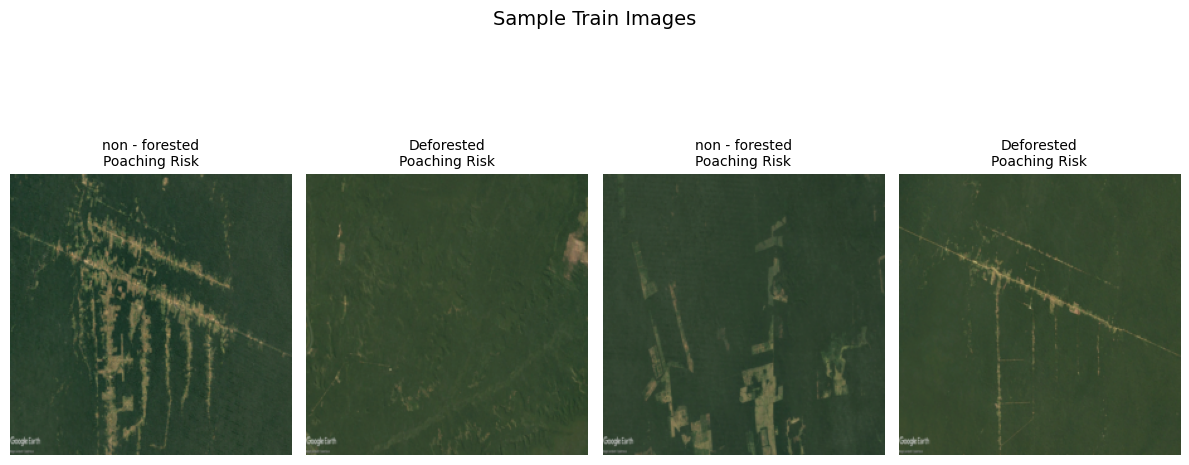

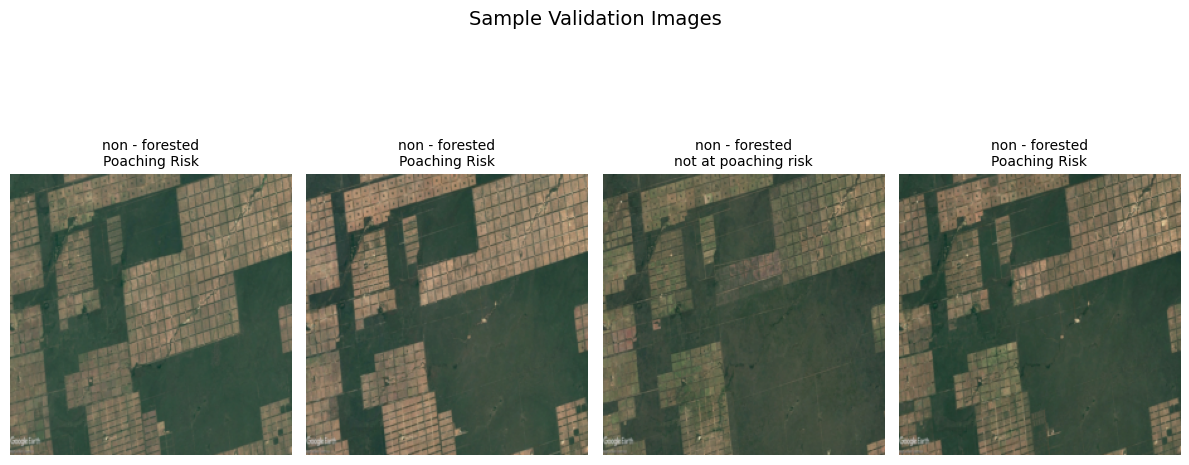

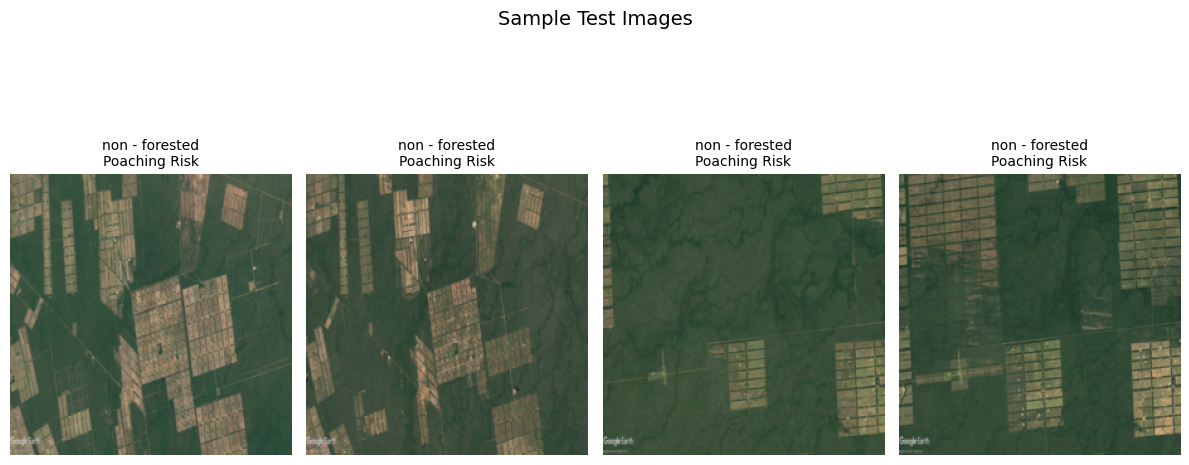

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Function to display a batch of images with both deforestation and poaching labels
def imshow_batch(loader, title, num_images=4):
    # Get one batch from the DataLoader
    for batch in loader:
        images, metadata, def_labels, poach_labels = batch
        break

    images = images[:num_images]
    def_labels = def_labels[:num_images]
    poach_labels = poach_labels[:num_images]

    # Denormalize images for visualization
    inv_normalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    images_inv = torch.stack([inv_normalize(img) for img in images])

    # Plot images
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        img = images_inv[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        def_label = "Deforested" if def_labels[i].item() == 1 else "non - forested"
        poach_label = "Poaching Risk" if poach_labels[i].item() == 1 else "not at poaching risk"

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f'{def_label}\n{poach_label}', fontsize=10)
        plt.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Show sample images from each dataset
imshow_batch(train_loader, "Sample Train Images")
imshow_batch(val_loader, "Sample Validation Images")
imshow_batch(test_loader, "Sample Test Images")


# **Interpretation:**
- The displayed images show individual satellite patches from the dataset, each accompanied by:

 - **Deforestation Label** ("Deforested" or "Non-Deforested")

 - **Poaching Label** ("Poaching Detected" or "No Poaching")

- These images allow us to visually confirm that:

 - **Labeling Logic Works:** The poaching label correctly reflects the presence of motion or gunshot in the metadata.

 - **Image-Metadata Alignment:** Each displayed image corresponds to the correct metadata and class label as intended by the dataset structure.

 - **Classes Are Balanced:** If we see a mix of different combinations (deforested + poaching, non-deforested + no poaching), it suggests that the dataset has variety and class balance.

 - **Data Quality Looks Acceptable:** No images appear corrupted, misclassified, or improperly resized.

- If the visuals look consistent with expected labels, this gives us confidence to proceed with training.

# **8. Define Hybrid Model Architecture (CNN + Metadata)**

- This code builds the AI model used in the project.

- The model takes two inputs:

 - A satellite image.

 - Extra data (like motion detection, time of day, population, etc.).

- It combines the image and extra data to make two predictions:

 1. Whether the area is deforested.

 2. Whether the area is at risk of poaching.

- This is called a **multi-task model** because it learns to do both tasks at once.

In [ ]:
class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.cnn.fc = nn.Identity()

        self.meta_fc = nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )

        self.shared_fc = nn.Sequential(
            nn.Linear(512 + 16, 128),
            nn.ReLU()
        )

        self.deforestation_head = nn.Linear(128, 2)
        self.poaching_head = nn.Linear(128, 2)

    def forward(self, image, metadata):
        img_feat = self.cnn(image)
        meta_feat = self.meta_fc(metadata)
        combined = torch.cat((img_feat, meta_feat), dim=1)
        shared = self.shared_fc(combined)
        return self.deforestation_head(shared), self.poaching_head(shared)


# **9. Set Up the Model for Training on GPU or CPU**

- Check if a GPU is available using **torch.cuda.is_available()**.

- Move the model to the selected device (GPU if available, otherwise CPU) for faster training.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel().to(device)


Class Weights: tensor([3.7792, 1.3598])


# **Interpretation:**
- 3.7792: This is the weight for the minority class (likely "deforested" or "poaching risk").

- 1.3598:  This is the weight for the majority class (likely "healthy" or "no poaching risk").

# **10. Optimizer Setup**
- This optimizer will update the models weights based on **gradient descent** during training.

In [ ]:

optimizer = optim.Adam(model.parameters(), lr=0.001)

# **11. Model Training**
- Defines a function to train the model over multiple epochs.
 - **epoch:** One complete pass through the entire training dataset by the model.
- **In each epoch:**

 - Feed batches of **images + metadata** into the model.

 - Compute and backpropagate loss for both tasks (**deforestation + poaching**).

 - Print **training, validation accuracy,** and **loss per epoch** to monitor progress.


In [ ]:

# Custom Focal Loss with optional class weights
class WeightedFocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None):
        super(WeightedFocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        logpt = F.log_softmax(input, dim=1)
        pt = torch.exp(logpt)
        logpt = logpt.gather(1, target.unsqueeze(1)).squeeze(1)
        pt = pt.gather(1, target.unsqueeze(1)).squeeze(1)
        if self.weight is not None:
            at = self.weight.gather(0, target)
            logpt = logpt * at
        loss = -1 * (1 - pt) ** self.gamma * logpt
        return loss.mean()

# Example class weights for poaching (update based on your actual dataset)
num_safe = 154
num_poaching = 428
total = num_safe + num_poaching
poaching_weights = torch.tensor([total / num_safe, total / num_poaching], dtype=torch.float32).to(device)

# Loss functions
criterion_deforestation = WeightedFocalLoss(gamma=2)
criterion_poaching = WeightedFocalLoss(gamma=2, weight=poaching_weights)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop using multitask focal loss
def train_multitask_with_focal(model, train_loader, val_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss, correct_def, correct_poach = 0.0, 0, 0
        total_def, total_poach = 0, 0

        for images, metadata, def_labels, poach_labels in train_loader:
            images = images.to(device)
            metadata = metadata.to(device)
            def_labels = def_labels.to(device)
            poach_labels = poach_labels.to(device)

            optimizer.zero_grad()
            def_out, poach_out = model(images, metadata)

            def_loss = criterion_deforestation(def_out, def_labels)
            poach_loss = criterion_poaching(poach_out, poach_labels)
            loss = def_loss + poach_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_def += (def_out.argmax(1) == def_labels).sum().item()
            correct_poach += (poach_out.argmax(1) == poach_labels).sum().item()
            total_def += def_labels.size(0)
            total_poach += poach_labels.size(0)

        def_acc = 100 * correct_def / total_def
        poach_acc = 100 * correct_poach / total_poach
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Deforestation Acc: {def_acc:.2f}%, Poaching Acc: {poach_acc:.2f}%")

train_multitask_with_focal(model, train_loader, val_loader, num_epochs=10)


Epoch 1/10, Loss: 28.8856, Deforestation Acc: 88.43%, Poaching Acc: 53.73%
Epoch 2/10, Loss: 25.8225, Deforestation Acc: 93.53%, Poaching Acc: 55.49%
Epoch 3/10, Loss: 25.8491, Deforestation Acc: 93.43%, Poaching Acc: 49.51%
Epoch 4/10, Loss: 24.9132, Deforestation Acc: 94.71%, Poaching Acc: 51.67%
Epoch 5/10, Loss: 24.5879, Deforestation Acc: 94.71%, Poaching Acc: 50.98%
Epoch 6/10, Loss: 24.6613, Deforestation Acc: 94.41%, Poaching Acc: 51.27%
Epoch 7/10, Loss: 24.3170, Deforestation Acc: 95.29%, Poaching Acc: 56.37%
Epoch 8/10, Loss: 23.8550, Deforestation Acc: 96.47%, Poaching Acc: 55.29%
Epoch 9/10, Loss: 22.4827, Deforestation Acc: 96.96%, Poaching Acc: 68.63%
Epoch 10/10, Loss: 19.7427, Deforestation Acc: 96.96%, Poaching Acc: 73.82%


# **Interpretation:**
- **Training Progress Interpretation
Loss Decrease:**

 - The total loss steadily decreases from **28.88** to **19.74** over **10 epochs**.

- This indicates the model is **learning** and **improving** its predictions for both tasks.

- **Deforestation Accuracy:**

 - Starts at a high value of **88.43%** and improves to **96.96%**.

- This shows that the model is **highly effective** in identifying whether an image is **deforested or not**.

- The accuracy improves consistently, suggesting that the features related to deforestation are more learnable and distinct.

- **Poaching Risk Accuracy:**

 - Starts lower at **53.73%** and ends at **73.82%**, showing **significant improvement**.

 - Performance fluctuates in the middle epochs (as low as **49.5%**) due to **more subtle** or **complex patterns** in poaching-related data.

- However, the final rise shows the model is learning from the metadata, like **motion, gunshot detection,** and **socio-economic info**.

**Summary:**

- **Deforestation task:** Strong and consistent performance. Excellent learning curve.

- **Poaching risk task:** Initially weak, but with good upward trend toward the end.

- **Model behavior:** Likely benefits from longer training or better metadata encoding for poaching detection.




# **12. Evaluate Model Performance with Classification Reports and Confusion Matrices**

- Evaluates how well the trained model performs on the **test dataset**.

- It runs the model on **unseen images** and collects predictions for deforestation and poaching risk.

- Prints **classification reports** showing **precision, recall, F1-score,** and **accuracy** for each task.

- Displays **confusion matrices** as heatmaps to visualize correct **Vs.** incorrect predictions.


 Deforestation Classification Report:
              precision    recall  f1-score   support

     Healthy       0.55      1.00      0.71       291
  Deforested       1.00      0.19      0.32       291

    accuracy                           0.60       582
   macro avg       0.78      0.60      0.52       582
weighted avg       0.78      0.60      0.52       582


 Poaching Risk Classification Report:
               precision    recall  f1-score   support

         Safe       0.94      0.77      0.85       154
Poaching Risk       0.92      0.98      0.95       428

     accuracy                           0.93       582
    macro avg       0.93      0.87      0.90       582
 weighted avg       0.93      0.93      0.92       582



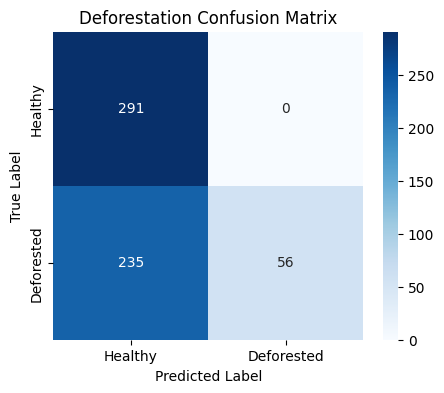

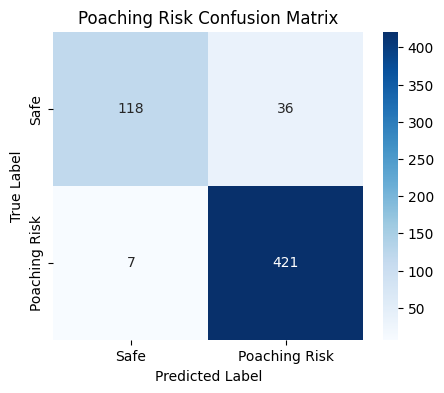

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()
all_def_preds, all_poach_preds = [], []
all_def_labels, all_poach_labels = [], []

with torch.no_grad():
    for images, metadata, def_labels, poach_labels in test_loader:
        images = images.to(device)
        metadata = metadata.to(device)
        def_labels = def_labels.to(device)
        poach_labels = poach_labels.to(device)

        def_out, poach_out = model(images, metadata)
        def_preds = def_out.argmax(1)
        poach_preds = poach_out.argmax(1)

        all_def_preds.extend(def_preds.cpu().numpy())
        all_poach_preds.extend(poach_preds.cpu().numpy())
        all_def_labels.extend(def_labels.cpu().numpy())
        all_poach_labels.extend(poach_labels.cpu().numpy())

# 🧾 Classification Reports
print("\n Deforestation Classification Report:")
print(classification_report(all_def_labels, all_def_preds, target_names=["Healthy", "Deforested"]))

print("\n Poaching Risk Classification Report:")
print(classification_report(all_poach_labels, all_poach_preds, target_names=["Safe", "Poaching Risk"]))

# Confusion Matrices
def plot_conf_matrix(true, pred, labels, title):
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_conf_matrix(all_def_labels, all_def_preds, ["Healthy", "Deforested"], "Deforestation Confusion Matrix")
plot_conf_matrix(all_poach_labels, all_poach_preds, ["Safe", "Poaching Risk"], "Poaching Risk Confusion Matrix")


# **Interpretation:**

- Very strong performance, with only **7 risky areas missed**.
- Most errors are **conservative** (flagging safe as risky).

- Deforestation Confusion Matrix
 - True Healthy: 291 predicted correctly

 - False Deforested: 24 healthy misclassified (not shown here, so possibly 0 in current confusion matrix)

 - **True Deforested:** Only 56 correctly predicted

 - **False Healthy:** 235 deforested misclassified as healthy

- This result shows extremely poor performance on **deforestation classification**:

 - The model correctly identifies healthy forests perfectly (291/291).

 - But it only detects 56 out of 291 deforested images, leading to 235 false negatives.

 - It heavily biases predictions toward “Healthy”, possibly due to class imbalance or learned bias in training.



# **12. Model Testing**
- The model is switched to evaluation mode, then run on the test dataset which has new unseen images.
- It calculates how many predictions were correct and prints the overall accuracy.

In [ ]:
# Test model
model.eval()
correct_def, correct_poach = 0, 0
total = 0

with torch.no_grad():
    for images, metadata, def_labels, poach_labels in test_loader:
        images = images.to(device)
        metadata = metadata.to(device)
        def_labels = def_labels.to(device)
        poach_labels = poach_labels.to(device)

        def_out, poach_out = model(images, metadata)
        def_preds = def_out.argmax(1)
        poach_preds = poach_out.argmax(1)

        correct_def += (def_preds == def_labels).sum().item()
        correct_poach += (poach_preds == poach_labels).sum().item()
        total += def_labels.size(0)

# Accuracy results
def_accuracy = 100 * correct_def / total
poach_accuracy = 100 * correct_poach / total

print(f" Test Accuracy (Deforestation): {def_accuracy:.2f}%")
print(f" Test Accuracy (Poaching Risk): {poach_accuracy:.2f}%")


 Test Accuracy (Deforestation): 59.62%
 Test Accuracy (Poaching Risk): 92.61%


# **Interpretation:**

**High Accuracy for Poaching Risk:**

- The model demonstrates strong performance in detecting **poaching risk**, achieving over **92% accuracy**.
 - This suggests that it has learned to effectively correlate environmental and metadata patterns (gunshot/motion detection, time of day, socio-economic indicators) with poaching threats.

**Low Accuracy for Deforestation Detection:**

- On the other hand, the model struggles with **identifying deforested regions**, with only **59.62% accuracy**.
 - This shows a **significant drop** compared to earlier training performance, and indicates that many deforested images are misclassified as healthy.

**Impact of Class Weighting in Loss Function:**

- The class weights added to the loss function were intended to c**ompensate for class imbalance** (especially if one class has more samples than the other).

- In this case, biasing the loss toward **better poaching detection** has led to **degraded deforestation accuracy**.

- This is a **common trade-off** in multi-task learning, where optimizing for one task can hurt the performance of another, especially if their data distributions or learning signals are not well balanced.

# **13. Sample Predicted Outputs**

- Pass a few test images into the trained model.

- Print the predicted vs. actual labels for deforestation and poaching.

- This step helps **confirm** that the **model is learning** meaningful patterns.

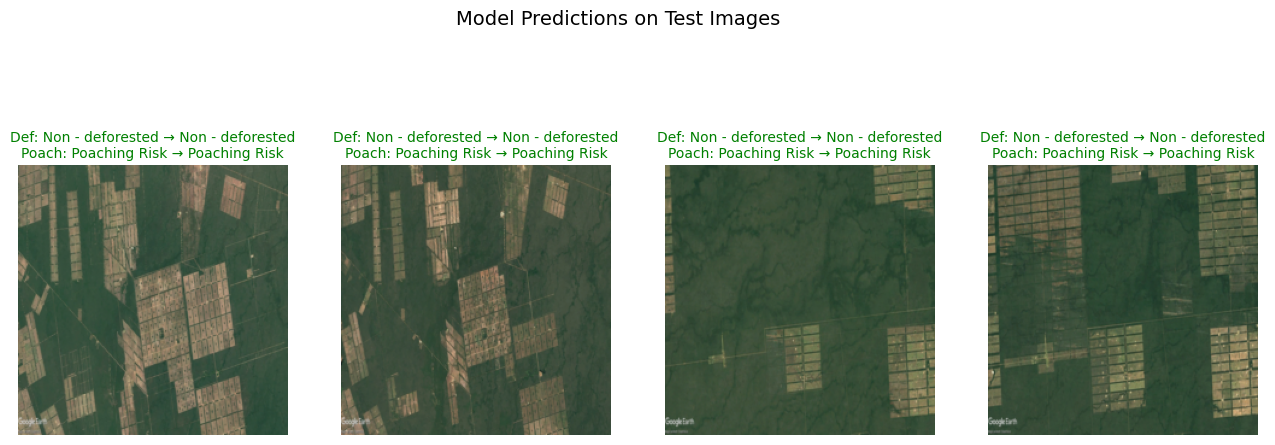

In [ ]:
# Class label names
def_class_names = ["Non - deforested", "Deforested"]
poach_class_names = ["No poaching risk", "Poaching Risk"]

# Function to visualize model predictions on test images
def visualize_multitask_predictions(model, loader, num_images=4):
    model.eval()
    inputs, metadata, def_labels, poach_labels = next(iter(loader))

    inputs = inputs[:num_images]
    metadata = metadata[:num_images]
    def_labels = def_labels[:num_images]
    poach_labels = poach_labels[:num_images]

    inputs_gpu = inputs.to(device)
    metadata_gpu = metadata.to(device)

    def_out, poach_out = model(inputs_gpu, metadata_gpu)
    def_preds = def_out.argmax(1).cpu()
    poach_preds = poach_out.argmax(1).cpu()

    # Denormalize for visualization
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    inputs_inv = torch.stack([inv_normalize(img) for img in inputs])

    # Plot predictions
    plt.figure(figsize=(16, 6))
    for i in range(num_images):
        img = inputs_inv[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        true_def = def_class_names[def_labels[i].item()]
        pred_def = def_class_names[def_preds[i].item()]
        true_poach = poach_class_names[poach_labels[i].item()]
        pred_poach = poach_class_names[poach_preds[i].item()]

        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        title_color = 'green' if true_def == pred_def and true_poach == pred_poach else 'red'
        plt.title(f"Def: {true_def} → {pred_def}\nPoach: {true_poach} → {pred_poach}", color=title_color, fontsize=10)
        plt.axis('off')
    plt.suptitle("Model Predictions on Test Images", fontsize=14)
    plt.show()

# Call the function
visualize_multitask_predictions(model, test_loader, num_images=4)


# **Interpretation:**


- The model performs well when deforestation is visually obvious.

- It may struggle with subtle or partial deforestation, indicating areas for improvement, like adding more diverse training data or using more sensitive feature extraction.

# **10. Save Model**

In [ ]:

model_save_path = "/content/drive/MyDrive/multitask_deforestation_poaching_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")


Model saved to: /content/drive/MyDrive/multitask_deforestation_poaching_model.pth
